# ppigeniepath

Epoch: 01, Loss: 0.5643, Val: 0.4973, Test: 0.4980
Epoch: 02, Loss: 0.5226, Val: 0.5139, Test: 0.5169
Epoch: 03, Loss: 0.5023, Val: 0.5228, Test: 0.5286
Epoch: 04, Loss: 0.4747, Val: 0.6092, Test: 0.6191
Epoch: 05, Loss: 0.4370, Val: 0.6421, Test: 0.6556
Epoch: 06, Loss: 0.3970, Val: 0.6883, Test: 0.7057
Epoch: 07, Loss: 0.3550, Val: 0.6699, Test: 0.6915
Epoch: 08, Loss: 0.3244, Val: 0.7485, Test: 0.7701
Epoch: 09, Loss: 0.2948, Val: 0.7645, Test: 0.7866
Epoch: 10, Loss: 0.2542, Val: 0.8097, Test: 0.8312
Epoch: 11, Loss: 0.2190, Val: 0.8311, Test: 0.8535
Epoch: 12, Loss: 0.1937, Val: 0.8331, Test: 0.8536
Epoch: 13, Loss: 0.1986, Val: 0.8431, Test: 0.8644
Epoch: 14, Loss: 0.1932, Val: 0.8389, Test: 0.8618
Epoch: 15, Loss: 0.1754, Val: 0.8542, Test: 0.8767
Epoch: 16, Loss: 0.1572, Val: 0.8778, Test: 0.8976
Epoch: 17, Loss: 0.1403, Val: 0.8794, Test: 0.9007
Epoch: 18, Loss: 0.1436, Val: 0.8781, Test: 0.8971
Epoch: 19, Loss: 0.1331, Val: 0.8826, Test: 0.9019
Epoch: 20, Loss: 0.1378, Val: 0

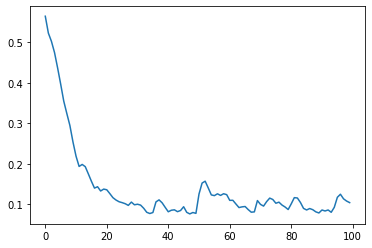

CPU times: user 44min 46s, sys: 3min 53s, total: 48min 39s
Wall time: 3min 39s


In [1]:
%%time
import argparse
import os.path as osp

import torch
from torch_geometric.datasets import PPI
from torch_geometric.data import DataLoader
from torch_geometric.nn import GATConv
from sklearn.metrics import f1_score

# parser = argparse.ArgumentParser()
# parser.add_argument('--model', type=str, default='GeniePathLazy')
# args = parser.parse_args()
# assert args.model in ['GeniePath', 'GeniePathLazy']

path = osp.join('./', 'data', 'PPI')
train_dataset = PPI(path, split='train')
val_dataset = PPI(path, split='val')
test_dataset = PPI(path, split='test')
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

dim = 256
lstm_hidden = 256
layer_num = 4


class Breadth(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Breadth, self).__init__()
        self.gatconv = GATConv(in_dim, out_dim, heads=1)#这里in_dim和out_dim都=dim=256
        # self.gatconv = GATConv(256, 256, heads=1)

    def forward(self, x, edge_index):
        x = torch.tanh(self.gatconv(x, edge_index))
        return x


class Depth(torch.nn.Module):
    def __init__(self, in_dim, hidden):
        super(Depth, self).__init__()
        self.lstm = torch.nn.LSTM(in_dim, hidden, 1, bias=False)

    def forward(self, x, h, c):
        x, (h, c) = self.lstm(x, (h, c))
        return x, (h, c)


class GeniePathLayer(torch.nn.Module):
    def __init__(self, in_dim):
        super(GeniePathLayer, self).__init__()
        self.breadth_func = Breadth(in_dim, dim)
        self.depth_func = Depth(dim, lstm_hidden)

    def forward(self, x, edge_index, h, c):
        x = self.breadth_func(x, edge_index)
        x = x[None, :]
        x, (h, c) = self.depth_func(x, h, c)
        x = x[0]
        return x, (h, c)


class GeniePath(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePath, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.gplayers = torch.nn.ModuleList(
            [GeniePathLayer(dim) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(dim, out_dim)

    def forward(self, x, edge_index):
        x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        for i, l in enumerate(self.gplayers):
            x, (h, c) = self.gplayers[i](x, edge_index, h, c)
        x = self.lin2(x)
        return x


class GeniePathLazy(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePathLazy, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.breadths = torch.nn.ModuleList(
            [Breadth(dim, dim) for i in range(layer_num)])
        self.depths = torch.nn.ModuleList(
            [Depth(dim * 2, lstm_hidden) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(dim, out_dim)

    def forward(self, x, edge_index):
        x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        h_tmps = []
        for i, l in enumerate(self.breadths):
            h_tmps.append(self.breadths[i](x, edge_index))
        x = x[None, :]
        for i, l in enumerate(self.depths):
            in_cat = torch.cat((h_tmps[i][None, :], x), -1)
            x, (h, c) = self.depths[i](in_cat, h, c)
        x = self.lin2(x[0])
        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kwargs = {'GeniePath': GeniePath, 'GeniePathLazy': GeniePathLazy}
model = GeniePathLazy(train_dataset.num_features,
                           train_dataset.num_classes).to(device)
loss_op = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)


def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        num_graphs = data.num_graphs
        data.batch = None
        data = data.to(device)
        optimizer.zero_grad()
        loss = loss_op(model(data.x, data.edge_index), data.y)
        total_loss += loss.item() * num_graphs
        loss.backward()
        optimizer.step()
    return total_loss / len(train_loader.dataset)


def test(loader):
    model.eval()

    ys, preds = [], []
    for data in loader:
        ys.append(data.y)
        with torch.no_grad():
            out = model(data.x.to(device), data.edge_index.to(device))
        preds.append((out > 0).float().cpu())

    y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
    return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0

losslist_ppigeniepath=[]
for epoch in range(1, 101):
    loss = train()
    losslist_ppigeniepath.append(loss)
    val_f1 = test(val_loader)
    test_f1 = test(test_loader)
    print('Epoch: {:02d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'.format(
        epoch, loss, val_f1, test_f1))
from matplotlib import pyplot as plt 
%matplotlib inline

plt.plot(losslist_ppigeniepath)
plt.show()

In [2]:
len(train_loader.dataset)

20

# sgeniepath v1 AGNN

Epoch: 01, Loss: 0.5771, Val: 0.4285, Test: 0.4302
Epoch: 02, Loss: 0.5351, Val: 0.5369, Test: 0.5420
Epoch: 03, Loss: 0.5103, Val: 0.5219, Test: 0.5301
Epoch: 04, Loss: 0.4663, Val: 0.6091, Test: 0.6199
Epoch: 05, Loss: 0.4234, Val: 0.6461, Test: 0.6605
Epoch: 06, Loss: 0.3701, Val: 0.7052, Test: 0.7213
Epoch: 07, Loss: 0.3181, Val: 0.7397, Test: 0.7589
Epoch: 08, Loss: 0.2631, Val: 0.8044, Test: 0.8243
Epoch: 09, Loss: 0.2118, Val: 0.8390, Test: 0.8605
Epoch: 10, Loss: 0.1693, Val: 0.8770, Test: 0.8967
Epoch: 11, Loss: 0.1351, Val: 0.8980, Test: 0.9176
Epoch: 12, Loss: 0.1087, Val: 0.9171, Test: 0.9364
Epoch: 13, Loss: 0.0885, Val: 0.9284, Test: 0.9466
Epoch: 14, Loss: 0.0747, Val: 0.9383, Test: 0.9557
Epoch: 15, Loss: 0.0627, Val: 0.9445, Test: 0.9599
Epoch: 16, Loss: 0.0552, Val: 0.9497, Test: 0.9645
Epoch: 17, Loss: 0.0488, Val: 0.9538, Test: 0.9680
Epoch: 18, Loss: 0.0445, Val: 0.9539, Test: 0.9681
Epoch: 19, Loss: 0.0402, Val: 0.9572, Test: 0.9708
Epoch: 20, Loss: 0.0370, Val: 0

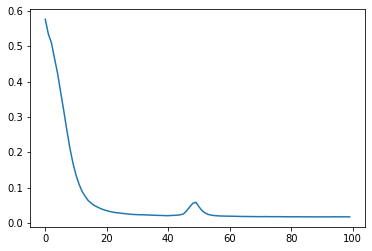

CPU times: user 39min 5s, sys: 3min 9s, total: 42min 14s
Wall time: 2min 43s


In [3]:
%%time
%matplotlib inline
import argparse
import os.path as osp

import torch
from torch_geometric.datasets import PPI
from torch_geometric.data import DataLoader
from torch_geometric.nn import GATConv
from torch_geometric.nn import AGNNConv

from sklearn.metrics import f1_score

# parser = argparse.ArgumentParser()
# parser.add_argument('--model', type=str, default='GeniePathLazy')
# args = parser.parse_args()
# assert args.model in ['GeniePath', 'GeniePathLazy']

path = osp.join('./', 'data', 'PPI')
train_dataset = PPI(path, split='train')
val_dataset = PPI(path, split='val')
test_dataset = PPI(path, split='test')
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

dim = 256
lstm_hidden = 256
layer_num = 4

# class agnnn(torch.nn.Module):
#     def __init__(self,in_dim,out_dim):
#         super(agnnn, self).__init__()
#         self.lin1 = torch.nn.Linear(in_dim, 16)
#         self.prop1 = AGNNConv(requires_grad=False)
#         self.prop2 = AGNNConv(requires_grad=True)
#         self.lin2 = torch.nn.Linear(16, out_dim)

#     def forward(self):
#         x = F.dropout(data.x, training=self.training)
#         x = F.relu(self.lin1(x))
#         x = self.prop1(x, edge_index)
#         x = self.prop2(x, edge_index)
#         x = F.dropout(x, training=self.training)
#         x = self.lin2(x)
#         return x
        
class Breadth(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Breadth, self).__init__()
        self.gatconv = AGNNConv(requires_grad=True)

    def forward(self, x, edge_index):
        x = torch.tanh(self.gatconv(x, edge_index))
        return x



class Depth(torch.nn.Module):
    def __init__(self, in_dim, hidden):
        super(Depth, self).__init__()
        self.lstm = torch.nn.LSTM(in_dim, hidden, 1, bias=False)

    def forward(self, x, h, c):
        x, (h, c) = self.lstm(x, (h, c))
        return x, (h, c)


class GeniePathLayer(torch.nn.Module):
    def __init__(self, in_dim):
        super(GeniePathLayer, self).__init__()
        self.breadth_func = Breadth(in_dim, dim)
        self.depth_func = Depth(dim, lstm_hidden)

    def forward(self, x, edge_index, h, c):
        x = self.breadth_func(x, edge_index)
        x = x[None, :]
        x, (h, c) = self.depth_func(x, h, c)
        x = x[0]
        return x, (h, c)


class GeniePath(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePath, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.gplayers = torch.nn.ModuleList(
            [GeniePathLayer(dim) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(dim, out_dim)

    def forward(self, x, edge_index):
        x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        for i, l in enumerate(self.gplayers):
            x, (h, c) = self.gplayers[i](x, edge_index, h, c)
        x = self.lin2(x)
        return x


class GeniePathLazy(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePathLazy, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.breadths = torch.nn.ModuleList(
            [Breadth(dim, dim) for i in range(layer_num)])
        self.depths = torch.nn.ModuleList(
            [Depth(dim * 2, lstm_hidden) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(dim, out_dim)

    def forward(self, x, edge_index):
        x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        h_tmps = []
        for i, l in enumerate(self.breadths):
            h_tmps.append(self.breadths[i](x, edge_index))
        x = x[None, :]
        for i, l in enumerate(self.depths):
            in_cat = torch.cat((h_tmps[i][None, :], x), -1)
            x, (h, c) = self.depths[i](in_cat, h, c)
        x = self.lin2(x[0])
        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kwargs = {'GeniePath': GeniePath, 'GeniePathLazy': GeniePathLazy}
model = GeniePathLazy(train_dataset.num_features,
                           train_dataset.num_classes).to(device)
loss_op = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)


def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        num_graphs = data.num_graphs
        data.batch = None
        data = data.to(device)
        optimizer.zero_grad()
        loss = loss_op(model(data.x, data.edge_index), data.y)
        total_loss += loss.item() * num_graphs
        loss.backward()
        optimizer.step()
    return total_loss / len(train_loader.dataset)


def test(loader):
    model.eval()

    ys, preds = [], []
    for data in loader:
        ys.append(data.y)
        with torch.no_grad():
            out = model(data.x.to(device), data.edge_index.to(device))
        preds.append((out > 0).float().cpu())

    y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
    return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0

losslist_agnn=[]

for epoch in range(1, 101):
    loss = train()
    losslist_agnn.append(loss)
    val_f1 = test(val_loader)
    test_f1 = test(test_loader)
    print('Epoch: {:02d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'.format(
        epoch, loss, val_f1, test_f1))
from matplotlib import pyplot as plt 
%matplotlib inline

plt.plot(losslist_agnn)
plt.show()

In [ ]:
loss=[1,2,3,4]
from matplotlib import pyplot as plt 
%matplotlib inline

plt.plot(loss)
plt.show()

# sgeniepath v2 不加dropout

Epoch: 01, Loss: 0.5780, Val: 0.4224, Test: 0.4231
Epoch: 02, Loss: 0.5510, Val: 0.4089, Test: 0.4120
Epoch: 03, Loss: 0.5349, Val: 0.4711, Test: 0.4773
Epoch: 04, Loss: 0.5179, Val: 0.5107, Test: 0.5180
Epoch: 05, Loss: 0.5039, Val: 0.4328, Test: 0.4394
Epoch: 06, Loss: 0.4919, Val: 0.5487, Test: 0.5557
Epoch: 07, Loss: 0.4656, Val: 0.5544, Test: 0.5634
Epoch: 08, Loss: 0.4436, Val: 0.5754, Test: 0.5881
Epoch: 09, Loss: 0.4234, Val: 0.6277, Test: 0.6365
Epoch: 10, Loss: 0.4005, Val: 0.6458, Test: 0.6612
Epoch: 11, Loss: 0.3716, Val: 0.6845, Test: 0.7000
Epoch: 12, Loss: 0.3455, Val: 0.6840, Test: 0.7061
Epoch: 13, Loss: 0.3219, Val: 0.7303, Test: 0.7537
Epoch: 14, Loss: 0.2954, Val: 0.7587, Test: 0.7813
Epoch: 15, Loss: 0.2618, Val: 0.7612, Test: 0.7853
Epoch: 16, Loss: 0.2515, Val: 0.8046, Test: 0.8196
Epoch: 17, Loss: 0.2258, Val: 0.8084, Test: 0.8285
Epoch: 18, Loss: 0.2032, Val: 0.8180, Test: 0.8368
Epoch: 19, Loss: 0.1906, Val: 0.8467, Test: 0.8618
Epoch: 20, Loss: 0.1738, Val: 0

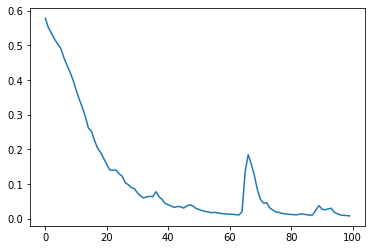

CPU times: user 51min 15s, sys: 4min 29s, total: 55min 44s
Wall time: 4min 4s


In [6]:
%%time
import argparse
import os.path as osp

import torch
from torch_geometric.datasets import PPI
from torch_geometric.data import DataLoader
from torch_geometric.nn import GATConv
from torch_geometric.nn import AGNNConv
import torch.nn.functional as F
from sklearn.metrics import f1_score

# parser = argparse.ArgumentParser()
# parser.add_argument('--model', type=str, default='GeniePathLazy')
# args = parser.parse_args()
# assert args.model in ['GeniePath', 'GeniePathLazy']

path = osp.join('./', 'data', 'PPI')
train_dataset = PPI(path, split='train')
val_dataset = PPI(path, split='val')
test_dataset = PPI(path, split='test')
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

dim = 256
lstm_hidden = 256
layer_num = 4

class Breadth(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Breadth, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, 32)
        self.prop1 = AGNNConv(requires_grad=False)
        self.prop2 = AGNNConv(requires_grad=True)
        self.lin2 = torch.nn.Linear(32, out_dim)
        # self.gatconv = AGNNConv(requires_grad=True)

    def forward(self, x, edge_index):
#         x = F.dropout(x, training=self.training)
        x = F.relu(self.lin1(x))
        x = self.prop1(x, edge_index)
        x = self.prop2(x, edge_index)
#         x = F.dropout(x, training=self.training)
        x = self.lin2(x)
        # x = torch.tanh(self.gatconv(x, edge_index))
        x = torch.tanh(x)
        return x



class Depth(torch.nn.Module):
    def __init__(self, in_dim, hidden):
        super(Depth, self).__init__()
        self.lstm = torch.nn.LSTM(in_dim, hidden, 1, bias=False)

    def forward(self, x, h, c):
        x, (h, c) = self.lstm(x, (h, c))
        return x, (h, c)


class GeniePathLayer(torch.nn.Module):
    def __init__(self, in_dim):
        super(GeniePathLayer, self).__init__()
        self.breadth_func = Breadth(in_dim, dim)
        self.depth_func = Depth(dim, lstm_hidden)

    def forward(self, x, edge_index, h, c):
        x = self.breadth_func(x, edge_index)
        x = x[None, :]
        x, (h, c) = self.depth_func(x, h, c)
        x = x[0]
        return x, (h, c)


class GeniePath(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePath, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.gplayers = torch.nn.ModuleList(
            [GeniePathLayer(dim) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(dim, out_dim)

    def forward(self, x, edge_index):
        x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        for i, l in enumerate(self.gplayers):
            x, (h, c) = self.gplayers[i](x, edge_index, h, c)
        x = self.lin2(x)
        return x


class GeniePathLazy(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePathLazy, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.breadths = torch.nn.ModuleList(
            [Breadth(dim, dim) for i in range(layer_num)])
        self.depths = torch.nn.ModuleList(
            [Depth(dim * 2, lstm_hidden) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(dim, out_dim)

    def forward(self, x, edge_index):
        x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        h_tmps = []
        for i, l in enumerate(self.breadths):
            h_tmps.append(self.breadths[i](x, edge_index))
        x = x[None, :]
        for i, l in enumerate(self.depths):
            in_cat = torch.cat((h_tmps[i][None, :], x), -1)
            x, (h, c) = self.depths[i](in_cat, h, c)
        x = self.lin2(x[0])
        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kwargs = {'GeniePath': GeniePath, 'GeniePathLazy': GeniePathLazy}
model = GeniePathLazy(train_dataset.num_features,
                           train_dataset.num_classes).to(device)
loss_op = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)


def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        num_graphs = data.num_graphs
        data.batch = None
        data = data.to(device)
        optimizer.zero_grad()
        loss = loss_op(model(data.x, data.edge_index), data.y)
        total_loss += loss.item() * num_graphs
        loss.backward()
        optimizer.step()
    return total_loss / len(train_loader.dataset)


def test(loader):
    model.eval()

    ys, preds = [], []
    for data in loader:
        ys.append(data.y)
        with torch.no_grad():
            out = model(data.x.to(device), data.edge_index.to(device))
        preds.append((out > 0).float().cpu())

    y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
    return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0


losslist=[]

for epoch in range(1, 101):
    loss = train()
    losslist.append(loss)
    val_f1 = test(val_loader)
    test_f1 = test(test_loader)
    print('Epoch: {:02d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'.format(
        epoch, loss, val_f1, test_f1))
from matplotlib import pyplot as plt 
%matplotlib inline

plt.plot(losslist)
plt.show()


# ppi_sgeniepathv3_sgc

Epoch: 01, Loss: 0.5691, Val: 0.4923, Test: 0.4949
Epoch: 02, Loss: 0.5291, Val: 0.4663, Test: 0.4689
Epoch: 03, Loss: 0.5123, Val: 0.5305, Test: 0.5378
Epoch: 04, Loss: 0.4876, Val: 0.5553, Test: 0.5641
Epoch: 05, Loss: 0.4566, Val: 0.5688, Test: 0.5840
Epoch: 06, Loss: 0.4080, Val: 0.6530, Test: 0.6703
Epoch: 07, Loss: 0.3520, Val: 0.7228, Test: 0.7473
Epoch: 08, Loss: 0.2943, Val: 0.7790, Test: 0.8046
Epoch: 09, Loss: 0.2396, Val: 0.8164, Test: 0.8426
Epoch: 10, Loss: 0.1980, Val: 0.8484, Test: 0.8737
Epoch: 11, Loss: 0.1645, Val: 0.8760, Test: 0.9003
Epoch: 12, Loss: 0.1347, Val: 0.8911, Test: 0.9157
Epoch: 13, Loss: 0.1144, Val: 0.9037, Test: 0.9277
Epoch: 14, Loss: 0.0977, Val: 0.9157, Test: 0.9394
Epoch: 15, Loss: 0.0822, Val: 0.9221, Test: 0.9452
Epoch: 16, Loss: 0.0734, Val: 0.9275, Test: 0.9488
Epoch: 17, Loss: 0.0649, Val: 0.9368, Test: 0.9570
Epoch: 18, Loss: 0.0577, Val: 0.9377, Test: 0.9567
Epoch: 19, Loss: 0.0530, Val: 0.9444, Test: 0.9620
Epoch: 20, Loss: 0.0476, Val: 0

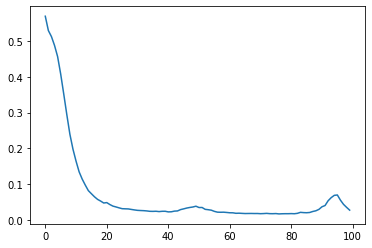

CPU times: user 36min 32s, sys: 2min 48s, total: 39min 21s
Wall time: 2min 29s


In [4]:
%%time
import argparse
import os.path as osp

import torch
from torch_geometric.datasets import PPI
from torch_geometric.data import DataLoader
from torch_geometric.nn import GATConv
from torch_geometric.nn import SGConv

from sklearn.metrics import f1_score

# parser = argparse.ArgumentParser()
# parser.add_argument('--model', type=str, default='GeniePathLazy')
# args = parser.parse_args()
# assert args.model in ['GeniePath', 'GeniePathLazy']

path = osp.join('./', 'data', 'PPI')
train_dataset = PPI(path, split='train')
val_dataset = PPI(path, split='val')
test_dataset = PPI(path, split='test')
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

dim = 256
lstm_hidden = 256
layer_num = 4


class Breadth(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Breadth, self).__init__()
        self.gatconv = SGConv(in_dim, out_dim)#, K=2,cached=True)#这里in_dim和out_dim都=dim=256
        # self.gatconv = GATConv(256, 256, heads=1)

    def forward(self, x, edge_index):
        x = torch.tanh(self.gatconv(x, edge_index))
        return x


class Depth(torch.nn.Module):
    def __init__(self, in_dim, hidden):
        super(Depth, self).__init__()
        self.lstm = torch.nn.LSTM(in_dim, hidden, 1, bias=False)

    def forward(self, x, h, c):
        x, (h, c) = self.lstm(x, (h, c))
        return x, (h, c)


class GeniePathLayer(torch.nn.Module):
    def __init__(self, in_dim):
        super(GeniePathLayer, self).__init__()
        self.breadth_func = Breadth(in_dim, dim)
        self.depth_func = Depth(dim, lstm_hidden)

    def forward(self, x, edge_index, h, c):
        x = self.breadth_func(x, edge_index)
        x = x[None, :]
        x, (h, c) = self.depth_func(x, h, c)
        x = x[0]
        return x, (h, c)


class GeniePath(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePath, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.gplayers = torch.nn.ModuleList(
            [GeniePathLayer(dim) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(dim, out_dim)

    def forward(self, x, edge_index):
        x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        for i, l in enumerate(self.gplayers):
            x, (h, c) = self.gplayers[i](x, edge_index, h, c)
        x = self.lin2(x)
        return x


class GeniePathLazy(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePathLazy, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.breadths = torch.nn.ModuleList(
            [Breadth(dim, dim) for i in range(layer_num)])
        self.depths = torch.nn.ModuleList(
            [Depth(dim * 2, lstm_hidden) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(dim, out_dim)

    def forward(self, x, edge_index):
        x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        h_tmps = []
        for i, l in enumerate(self.breadths):
            h_tmps.append(self.breadths[i](x, edge_index))
        x = x[None, :]
        for i, l in enumerate(self.depths):
            in_cat = torch.cat((h_tmps[i][None, :], x), -1)
            x, (h, c) = self.depths[i](in_cat, h, c)
        x = self.lin2(x[0])
        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kwargs = {'GeniePath': GeniePath, 'GeniePathLazy': GeniePathLazy}
model = GeniePathLazy (train_dataset.num_features,
                           train_dataset.num_classes).to(device)
loss_op = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)


def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        num_graphs = data.num_graphs
        data.batch = None
        data = data.to(device)
        optimizer.zero_grad()
        loss = loss_op(model(data.x, data.edge_index), data.y)
        total_loss += loss.item() * num_graphs
        loss.backward()
        optimizer.step()
    return total_loss / len(train_loader.dataset)


def test(loader):
    model.eval()

    ys, preds = [], []
    for data in loader:
        ys.append(data.y)
        with torch.no_grad():
            out = model(data.x.to(device), data.edge_index.to(device))
        preds.append((out > 0).float().cpu())

    y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
    return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0


losslist=[]

for epoch in range(1, 101):
    loss = train()
    losslist.append(loss)
    val_f1 = test(val_loader)
    test_f1 = test(test_loader)
    print('Epoch: {:02d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'.format(
        epoch, loss, val_f1, test_f1))
from matplotlib import pyplot as plt 
%matplotlib inline

plt.plot(losslist)
plt.show()


# 适配AGNN版本 v1

## AGNN之前先进行一次线性变换

Epoch: 01, Loss: 0.5796, Val: 0.4052, Test: 0.4051
Epoch: 02, Loss: 0.5558, Val: 0.4396, Test: 0.4407
Epoch: 03, Loss: 0.5466, Val: 0.4221, Test: 0.4261
Epoch: 04, Loss: 0.5296, Val: 0.4770, Test: 0.4845
Epoch: 05, Loss: 0.5086, Val: 0.5292, Test: 0.5367
Epoch: 06, Loss: 0.4909, Val: 0.4749, Test: 0.4842
Epoch: 07, Loss: 0.4742, Val: 0.5748, Test: 0.5832
Epoch: 08, Loss: 0.4526, Val: 0.5625, Test: 0.5746
Epoch: 09, Loss: 0.4366, Val: 0.6109, Test: 0.6241
Epoch: 10, Loss: 0.4217, Val: 0.6018, Test: 0.6165
Epoch: 11, Loss: 0.4050, Val: 0.6421, Test: 0.6586
Epoch: 12, Loss: 0.3838, Val: 0.6719, Test: 0.6883
Epoch: 13, Loss: 0.3678, Val: 0.6449, Test: 0.6640
Epoch: 14, Loss: 0.3511, Val: 0.6588, Test: 0.6782
Epoch: 15, Loss: 0.3493, Val: 0.7071, Test: 0.7251
Epoch: 16, Loss: 0.3238, Val: 0.7282, Test: 0.7493
Epoch: 17, Loss: 0.3037, Val: 0.7201, Test: 0.7412
Epoch: 18, Loss: 0.3001, Val: 0.7205, Test: 0.7411
Epoch: 19, Loss: 0.2794, Val: 0.7555, Test: 0.7774
Epoch: 20, Loss: 0.2622, Val: 0

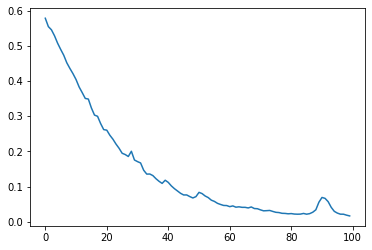

CPU times: user 1h 13min 52s, sys: 7min 18s, total: 1h 21min 11s
Wall time: 6min 18s


In [7]:
%%time
import argparse
import os.path as osp

import torch
from torch_geometric.datasets import PPI
from torch_geometric.data import DataLoader
from torch_geometric.nn import GATConv
from torch_geometric.nn import AGNNConv
import torch.nn.functional as F
from sklearn.metrics import f1_score

# parser = argparse.ArgumentParser()
# parser.add_argument('--model', type=str, default='GeniePathLazy')
# args = parser.parse_args()
# assert args.model in ['GeniePath', 'GeniePathLazy']

path = osp.join('./', 'data', 'PPI')
train_dataset = PPI(path, split='train')
val_dataset = PPI(path, split='val')
test_dataset = PPI(path, split='test')
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

dim = 256
lstm_hidden = 256
layer_num = 4

# class agnnn(torch.nn.Module):
#     def __init__(self,in_dim,out_dim):
#         super(agnnn, self).__init__()
#         self.lin1 = torch.nn.Linear(in_dim, 16)
#         self.prop1 = AGNNConv(requires_grad=False)
#         self.prop2 = AGNNConv(requires_grad=True)
#         self.lin2 = torch.nn.Linear(16, out_dim)

#     def forward(self):
#         x = F.dropout(data.x, training=self.training)
#         x = F.relu(self.lin1(x))
#         x = self.prop1(x, edge_index)
#         x = self.prop2(x, edge_index)
#         x = F.dropout(x, training=self.training)
#         x = self.lin2(x)
#         return x
        
class Breadth(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Breadth, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, out_dim)
        self.prop1 = AGNNConv(requires_grad=False)
        self.prop2 = AGNNConv(requires_grad=True)
        self.lin2 = torch.nn.Linear(out_dim, out_dim)
        # self.gatconv = AGNNConv(requires_grad=True)

    def forward(self, x, edge_index):
#         x = F.dropout(x, training=self.training)
        x = F.relu(self.lin1(x))#这里先进行一次lin1变换
        x = self.prop1(x, edge_index)
        x = self.prop2(x, edge_index)
#         x = F.dropout(x, training=self.training)
#         x = self.lin2(x)
        # x = torch.tanh(self.gatconv(x, edge_index))
        x = torch.tanh(x)
        return x



class Depth(torch.nn.Module):
    def __init__(self, in_dim, hidden):
        super(Depth, self).__init__()
        self.lstm = torch.nn.LSTM(in_dim, hidden, 1, bias=False)

    def forward(self, x, h, c):
        x, (h, c) = self.lstm(x, (h, c))
        return x, (h, c)


class GeniePathLayer(torch.nn.Module):
    def __init__(self, in_dim):
        super(GeniePathLayer, self).__init__()
        self.breadth_func = Breadth(in_dim, dim)
        self.depth_func = Depth(dim, lstm_hidden)

    def forward(self, x, edge_index, h, c):
        x = self.breadth_func(x, edge_index)
        x = x[None, :]
        x, (h, c) = self.depth_func(x, h, c)
        x = x[0]
        return x, (h, c)


class GeniePath(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePath, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.gplayers = torch.nn.ModuleList(
            [GeniePathLayer(dim) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(dim, out_dim)

    def forward(self, x, edge_index):
        x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        for i, l in enumerate(self.gplayers):
            x, (h, c) = self.gplayers[i](x, edge_index, h, c)
        x = self.lin2(x)
        return x


class GeniePathLazy(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePathLazy, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.breadths = torch.nn.ModuleList(
            [Breadth(dim, dim) for i in range(layer_num)])
        self.depths = torch.nn.ModuleList(
            [Depth(dim * 2, lstm_hidden) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(dim, out_dim)

    def forward(self, x, edge_index):
        x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        h_tmps = []
        for i, l in enumerate(self.breadths):
            h_tmps.append(self.breadths[i](x, edge_index))
        x = x[None, :]
        for i, l in enumerate(self.depths):
            in_cat = torch.cat((h_tmps[i][None, :], x), -1)
            x, (h, c) = self.depths[i](in_cat, h, c)
        x = self.lin2(x[0])
        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kwargs = {'GeniePath': GeniePath, 'GeniePathLazy': GeniePathLazy}
model = GeniePathLazy(train_dataset.num_features,
                           train_dataset.num_classes).to(device)
loss_op = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)


def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        num_graphs = data.num_graphs
        data.batch = None
        data = data.to(device)
        optimizer.zero_grad()
        loss = loss_op(model(data.x, data.edge_index), data.y)
        total_loss += loss.item() * num_graphs
        loss.backward()
        optimizer.step()
    return total_loss / len(train_loader.dataset)


def test(loader):
    model.eval()

    ys, preds = [], []
    for data in loader:
        ys.append(data.y)
        with torch.no_grad():
            out = model(data.x.to(device), data.edge_index.to(device))
        preds.append((out > 0).float().cpu())

    y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
    return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0


losslist=[]

for epoch in range(1, 101):
    loss = train()
    losslist.append(loss)
    val_f1 = test(val_loader)
    test_f1 = test(test_loader)
    print('Epoch: {:02d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'.format(
        epoch, loss, val_f1, test_f1))
from matplotlib import pyplot as plt 
%matplotlib inline

plt.plot(losslist)
plt.show()


## 同上

Epoch: 01, Loss: 0.5725, Val: 0.3780, Test: 0.3782
Epoch: 02, Loss: 0.5492, Val: 0.4400, Test: 0.4428
Epoch: 03, Loss: 0.5331, Val: 0.4595, Test: 0.4669
Epoch: 04, Loss: 0.5174, Val: 0.4741, Test: 0.4833
Epoch: 05, Loss: 0.4951, Val: 0.5073, Test: 0.5172
Epoch: 06, Loss: 0.4748, Val: 0.5622, Test: 0.5730
Epoch: 07, Loss: 0.4572, Val: 0.5881, Test: 0.5984
Epoch: 08, Loss: 0.4354, Val: 0.5796, Test: 0.5924
Epoch: 09, Loss: 0.4211, Val: 0.6153, Test: 0.6282
Epoch: 10, Loss: 0.4074, Val: 0.6317, Test: 0.6468
Epoch: 11, Loss: 0.3802, Val: 0.6785, Test: 0.6935
Epoch: 12, Loss: 0.3699, Val: 0.6739, Test: 0.6913
Epoch: 13, Loss: 0.3516, Val: 0.6953, Test: 0.7138
Epoch: 14, Loss: 0.3312, Val: 0.6691, Test: 0.6865
Epoch: 15, Loss: 0.3193, Val: 0.7045, Test: 0.7231
Epoch: 16, Loss: 0.3030, Val: 0.7320, Test: 0.7504
Epoch: 17, Loss: 0.2846, Val: 0.7418, Test: 0.7618
Epoch: 18, Loss: 0.2717, Val: 0.7636, Test: 0.7817
Epoch: 19, Loss: 0.2613, Val: 0.7798, Test: 0.7983
Epoch: 20, Loss: 0.2500, Val: 0

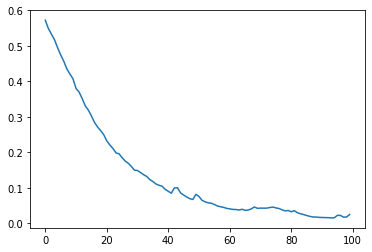

CPU times: user 1h 14min 44s, sys: 7min 10s, total: 1h 21min 54s
Wall time: 6min 14s


In [9]:
%%time
import argparse
import os.path as osp

import torch
from torch_geometric.datasets import PPI
from torch_geometric.data import DataLoader
from torch_geometric.nn import GATConv
from torch_geometric.nn import AGNNConv
import torch.nn.functional as F
from sklearn.metrics import f1_score

# parser = argparse.ArgumentParser()
# parser.add_argument('--model', type=str, default='GeniePathLazy')
# args = parser.parse_args()
# assert args.model in ['GeniePath', 'GeniePathLazy']

path = osp.join('./', 'data', 'PPI')
train_dataset = PPI(path, split='train')
val_dataset = PPI(path, split='val')
test_dataset = PPI(path, split='test')
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

dim = 256
lstm_hidden = 256
layer_num = 4

# class agnnn(torch.nn.Module):
#     def __init__(self,in_dim,out_dim):
#         super(agnnn, self).__init__()
#         self.lin1 = torch.nn.Linear(in_dim, 16)
#         self.prop1 = AGNNConv(requires_grad=False)
#         self.prop2 = AGNNConv(requires_grad=True)
#         self.lin2 = torch.nn.Linear(16, out_dim)

#     def forward(self):
#         x = F.dropout(data.x, training=self.training)
#         x = F.relu(self.lin1(x))
#         x = self.prop1(x, edge_index)
#         x = self.prop2(x, edge_index)
#         x = F.dropout(x, training=self.training)
#         x = self.lin2(x)
#         return x
        
class Breadth(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Breadth, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, out_dim)
        self.prop1 = AGNNConv(requires_grad=False)
        self.prop2 = AGNNConv(requires_grad=True)
        self.lin2 = torch.nn.Linear(out_dim, out_dim)
        # self.gatconv = AGNNConv(requires_grad=True)

    def forward(self, x, edge_index):
#         x = F.dropout(x, training=self.training)
        x = F.relu(self.lin1(x))
        x = self.prop1(x, edge_index)
        x = self.prop2(x, edge_index)
#         x = F.dropout(x, training=self.training)
#         x = self.lin2(x)
        # x = torch.tanh(self.gatconv(x, edge_index))
        x = torch.tanh(x)
        return x



class Depth(torch.nn.Module):
    def __init__(self, in_dim, hidden):
        super(Depth, self).__init__()
        self.lstm = torch.nn.LSTM(in_dim, hidden, 1, bias=False)

    def forward(self, x, h, c):
        x, (h, c) = self.lstm(x, (h, c))
        return x, (h, c)


class GeniePathLayer(torch.nn.Module):
    def __init__(self, in_dim):
        super(GeniePathLayer, self).__init__()
        self.breadth_func = Breadth(in_dim, dim)
        self.depth_func = Depth(dim, lstm_hidden)

    def forward(self, x, edge_index, h, c):
        x = self.breadth_func(x, edge_index)
        x = x[None, :]
        x, (h, c) = self.depth_func(x, h, c)
        x = x[0]
        return x, (h, c)


class GeniePath(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePath, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.gplayers = torch.nn.ModuleList(
            [GeniePathLayer(dim) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(dim, out_dim)

    def forward(self, x, edge_index):
        x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        for i, l in enumerate(self.gplayers):
            x, (h, c) = self.gplayers[i](x, edge_index, h, c)
        x = self.lin2(x)
        return x


class GeniePathLazy(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePathLazy, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.breadths = torch.nn.ModuleList(
            [Breadth(dim, dim) for i in range(layer_num)])
        self.depths = torch.nn.ModuleList(
            [Depth(dim * 2, lstm_hidden) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(dim, out_dim)

    def forward(self, x, edge_index):
        x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        h_tmps = []
        for i, l in enumerate(self.breadths):
            h_tmps.append(self.breadths[i](x, edge_index))
        x = x[None, :]
        for i, l in enumerate(self.depths):
            in_cat = torch.cat((h_tmps[i][None, :], x), -1)
            x, (h, c) = self.depths[i](in_cat, h, c)
        x = self.lin2(x[0])
        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
kwargs = {'GeniePath': GeniePath, 'GeniePathLazy': GeniePathLazy}
model = GeniePathLazy(train_dataset.num_features,
                           train_dataset.num_classes).to(device)
loss_op = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)


def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        num_graphs = data.num_graphs
        data.batch = None
        data = data.to(device)
        optimizer.zero_grad()
        loss = loss_op(model(data.x, data.edge_index), data.y)
        total_loss += loss.item() * num_graphs
        loss.backward()
        optimizer.step()
    return total_loss / len(train_loader.dataset)


def test(loader):
    model.eval()

    ys, preds = [], []
    for data in loader:
        ys.append(data.y)
        with torch.no_grad():
            out = model(data.x.to(device), data.edge_index.to(device))
        preds.append((out > 0).float().cpu())

    y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
    return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0


losslist=[]

for epoch in range(1, 101):
    loss = train()
    losslist.append(loss)
    val_f1 = test(val_loader)
    test_f1 = test(test_loader)
    print('Epoch: {:02d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'.format(
        epoch, loss, val_f1, test_f1))
from matplotlib import pyplot as plt 
%matplotlib inline

plt.plot(losslist)
plt.show()


## 不进行线性变换

Epoch: 01, Loss: 0.5726, Val: 0.3890, Test: 0.3894
Epoch: 02, Loss: 0.5520, Val: 0.4443, Test: 0.4464
Epoch: 03, Loss: 0.5444, Val: 0.4352, Test: 0.4395
Epoch: 04, Loss: 0.5348, Val: 0.4523, Test: 0.4583
Epoch: 05, Loss: 0.5163, Val: 0.4947, Test: 0.5033
Epoch: 06, Loss: 0.4972, Val: 0.5038, Test: 0.5142
Epoch: 07, Loss: 0.4786, Val: 0.5606, Test: 0.5734
Epoch: 08, Loss: 0.4586, Val: 0.5589, Test: 0.5722
Epoch: 09, Loss: 0.4414, Val: 0.5613, Test: 0.5765
Epoch: 10, Loss: 0.4310, Val: 0.6015, Test: 0.6160
Epoch: 11, Loss: 0.4161, Val: 0.6151, Test: 0.6301
Epoch: 12, Loss: 0.4031, Val: 0.6267, Test: 0.6427
Epoch: 13, Loss: 0.3933, Val: 0.6202, Test: 0.6361
Epoch: 14, Loss: 0.3813, Val: 0.6448, Test: 0.6601
Epoch: 15, Loss: 0.3731, Val: 0.6586, Test: 0.6741
Epoch: 16, Loss: 0.3607, Val: 0.6476, Test: 0.6660
Epoch: 17, Loss: 0.3520, Val: 0.6811, Test: 0.6986
Epoch: 18, Loss: 0.3399, Val: 0.6941, Test: 0.7113
Epoch: 19, Loss: 0.3335, Val: 0.6754, Test: 0.6972
Epoch: 20, Loss: 0.3229, Val: 0

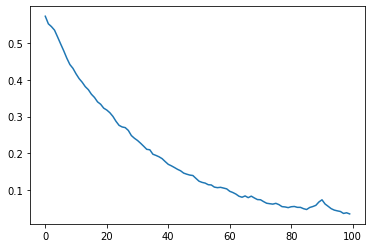

CPU times: user 1h 3min 38s, sys: 5min 33s, total: 1h 9min 11s
Wall time: 5min 10s


In [2]:
%%time
import argparse
import os.path as osp

import torch
from torch_geometric.datasets import PPI
from torch_geometric.data import DataLoader
from torch_geometric.nn import GATConv
from torch_geometric.nn import AGNNConv
import torch.nn.functional as F
from sklearn.metrics import f1_score

# parser = argparse.ArgumentParser()
# parser.add_argument('--model', type=str, default='GeniePathLazy')
# args = parser.parse_args()
# assert args.model in ['GeniePath', 'GeniePathLazy']

path = osp.join('./', 'data', 'PPI')
train_dataset = PPI(path, split='train')
val_dataset = PPI(path, split='val')
test_dataset = PPI(path, split='test')
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

dim = 256
lstm_hidden = 256
layer_num = 4

# class agnnn(torch.nn.Module):
#     def __init__(self,in_dim,out_dim):
#         super(agnnn, self).__init__()
#         self.lin1 = torch.nn.Linear(in_dim, 16)
#         self.prop1 = AGNNConv(requires_grad=False)
#         self.prop2 = AGNNConv(requires_grad=True)
#         self.lin2 = torch.nn.Linear(16, out_dim)

#     def forward(self):
#         x = F.dropout(data.x, training=self.training)
#         x = F.relu(self.lin1(x))
#         x = self.prop1(x, edge_index)
#         x = self.prop2(x, edge_index)
#         x = F.dropout(x, training=self.training)
#         x = self.lin2(x)
#         return x
        
class Breadth(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Breadth, self).__init__()
#         self.lin1 = torch.nn.Linear(in_dim, out_dim) #这一句在geniepath类中已经做过了线性变换，将原始特征维度变换为了dim
        self.prop1 = AGNNConv(requires_grad=False)
        self.prop2 = AGNNConv(requires_grad=True)
        self.lin2 = torch.nn.Linear(out_dim, out_dim)
        # self.gatconv = AGNNConv(requires_grad=True)

    def forward(self, x, edge_index):
#         x = F.dropout(x, training=self.training)
#         x = F.relu(self.lin1(x))
        x=F.relu(x)#对应修改 这里不进行lin1变换
        x = self.prop1(x, edge_index)
        x = self.prop2(x, edge_index)
#         x = F.dropout(x, training=self.training)
#         x = self.lin2(x)
        # x = torch.tanh(self.gatconv(x, edge_index))
        x = torch.tanh(x)
        return x



class Depth(torch.nn.Module):
    def __init__(self, in_dim, hidden):
        super(Depth, self).__init__()
        self.lstm = torch.nn.LSTM(in_dim, hidden, 1, bias=False)

    def forward(self, x, h, c):
        x, (h, c) = self.lstm(x, (h, c))
        return x, (h, c)


class GeniePathLayer(torch.nn.Module):
    def __init__(self, in_dim):
        super(GeniePathLayer, self).__init__()
        self.breadth_func = Breadth(in_dim, dim)
        self.depth_func = Depth(dim, lstm_hidden)

    def forward(self, x, edge_index, h, c):
        x = self.breadth_func(x, edge_index)
        x = x[None, :]
        x, (h, c) = self.depth_func(x, h, c)
        x = x[0]
        return x, (h, c)


class GeniePath(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePath, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.gplayers = torch.nn.ModuleList(
            [GeniePathLayer(dim) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(dim, out_dim)

    def forward(self, x, edge_index):
        x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        for i, l in enumerate(self.gplayers):
            x, (h, c) = self.gplayers[i](x, edge_index, h, c)
        x = self.lin2(x)
        return x


class GeniePathLazy(torch.nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GeniePathLazy, self).__init__()
        self.lin1 = torch.nn.Linear(in_dim, dim)
        self.breadths = torch.nn.ModuleList(
            [Breadth(dim, dim) for i in range(layer_num)])
        self.depths = torch.nn.ModuleList(
            [Depth(dim * 2, lstm_hidden) for i in range(layer_num)])
        self.lin2 = torch.nn.Linear(dim, out_dim)

    def forward(self, x, edge_index):
        x = self.lin1(x)
        h = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        c = torch.zeros(1, x.shape[0], lstm_hidden, device=x.device)
        h_tmps = []
        for i, l in enumerate(self.breadths):
            h_tmps.append(self.breadths[i](x, edge_index))
        x = x[None, :]
        for i, l in enumerate(self.depths):
            in_cat = torch.cat((h_tmps[i][None, :], x), -1)
            x, (h, c) = self.depths[i](in_cat, h, c)
        x = self.lin2(x[0])
        return x


device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
kwargs = {'GeniePath': GeniePath, 'GeniePathLazy': GeniePathLazy}
model = GeniePathLazy(train_dataset.num_features,
                           train_dataset.num_classes).to(device)
loss_op = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)


def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        num_graphs = data.num_graphs
        data.batch = None
        data = data.to(device)
        optimizer.zero_grad()
        loss = loss_op(model(data.x, data.edge_index), data.y)
        total_loss += loss.item() * num_graphs
        loss.backward()
        optimizer.step()
    return total_loss / len(train_loader.dataset)


def test(loader):
    model.eval()

    ys, preds = [], []
    for data in loader:
        ys.append(data.y)
        with torch.no_grad():
            out = model(data.x.to(device), data.edge_index.to(device))
        preds.append((out > 0).float().cpu())

    y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
    return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0


losslist=[]

for epoch in range(1, 101):
    loss = train()
    losslist.append(loss)
    val_f1 = test(val_loader)
    test_f1 = test(test_loader)
    print('Epoch: {:02d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'.format(
        epoch, loss, val_f1, test_f1))
from matplotlib import pyplot as plt 
%matplotlib inline

plt.plot(losslist)
plt.show()





In [2]:
%%time
print("fdafd")

fdafd
CPU times: user 316 µs, sys: 0 ns, total: 316 µs
Wall time: 253 µs


NameError: name 'losslist' is not defined